<a href="https://colab.research.google.com/github/lilyhuong/Bigdata-and-marketing/blob/master/Duplicate_twitter_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

<b><center><font size=22> Big data and Marketing Project</font></center></b>

**<font color = red>NGUYEN Thi Huong</font>**

**<font color = red>GNABA Ange-Michel</font>**

**<font color = salmon>MASTER 2 EBDS</font>**


**Subject: (B+) Text deduplication. With a dataset of your choice, using unsupervised learning techniques, identify duplicates or duplicated parts of a corpus** 

## Introduction and Loading librairies and dataset

In some situations, such as the search for the presence of plagiarism between two documents in the academic field or the verification of similarity in publications (tweets, etc.), it is important to have techniques which make it possible to identify possible duplications within ' 'a corpus. This is the case of text deduplication. As its name suggests, deduplication is used to check how similar several corpora are. These may be completely identical from a semantic point of view or may simply express the same idea without being completely the same. Thus, thanks to a set of pre-processing and techniques such as Bert, we can allow our machine to apply clustering or segmentation techniques to our dataset. It is with this in mind that we are going to perform natural language processing on a database that presents us with a set of tweets appearing during the first Corona crisis. These tweets are mainly in English and undergo a pre-processing first to make them usable in the rest of the work. Then, we will use the Bert-like sentence embeddings to represent our different sentences in the form of vectors and thus realize, based on mathematical considerations (calculation of distances), clustering or textual segmentations. It is important to note that a principal component analysis will also be performed to avoid being greatly impacted by the curse of dimensionality

In [ ]:
!pip install emoji demoji bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 18.0 MB/s 
     |████████████████████████████████| 42 kB 544 kB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=f9cae0295472d0df1768b9a5f3eadd266200393f66ed7a5affb1c7ff0fbe60c5
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
#Loading libraries
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer # preserves the root of words so that two words with the same stem will be considered as one and the same word
from nltk.stem.snowball import SnowballStemmer
import emoji #to clean emojis
import demoji #to clean emojis
import pickle #to save serialized data
from sklearn.decomposition import PCA #PCA
from sklearn.cluster import KMeans, DBSCAN #clustering methods
demoji.download_codes() #downloading emojis
import re

<ipython-input-2-202415dfc64c>:15: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes() #downloading emojis


Description of the dataset : TweetsCOV19 is a semantically annotated corpus of Tweets about the COVID-19 pandemic

In [ ]:
from bs4 import BeautifulSoup #to remove web characters

In [ ]:
from tqdm.notebook import tqdm #progress bar

In [ ]:
# loading dataset
link_file = "https://raw.githubusercontent.com/lilyhuong/Bigdata-and-marketing/e270465ec5686145b9f0f5f6b67e535e649ac72a/data.csv?token=GHSAT0AAAAAAB23GAORQE4WNWOEKWS66FEMY3UD2QQ"
df = pd.read_csv(link_file, index_col= 0)

In [ ]:
df.reset_index(inplace = True, drop = True)

In [ ]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,GoodMorningWilton,"Wilton, CT 06897","#WiltonCT's go-to news source. Daily, GOOD new...",2013-04-03 19:13:57,1234,451,765,False,2020-07-31 17:34:35,"Analyzing School Reopening Details, Wilton BOE...",NaN,TweetDeck,False
1,Mitchel Bell,Washington DC Metro,Uber sales guy - Hunter - Focus is on sales pe...,2010-02-20 19:28:20,83,92,7,False,2020-08-01 19:00:19,NICE Satmetrix Benchmark finds 57% of contact ...,NaN,Oktopost,False
2,PIB India,New Delhi,Press Information Bureau. Nodal agency for com...,2010-12-27 11:55:36,2063891,265,2149,True,2020-07-25 10:05:16,"#CoronaWatch\n\n◾ 13,36,861 total confirmed ca...",['CoronaWatch'],Twitter Web App,False
3,Daniel Mumby,Chard,"Christian, journalist, film buff, cricket fan ...",2012-07-08 15:15:19,678,981,8961,False,2020-08-04 07:52:32,"""XR f***s up so often because we became way to...",NaN,Twitter for Android,False
4,Jimmy Kokinakes,"Kankakee, IL","There are no small audiences, only small comic...",2014-05-31 18:52:32,1112,2081,8843,False,2020-08-18 16:17:44,@realDonaldTrump America's most DISGRUNTLED EM...,['COVID19'],Twitter Web App,False


In [ ]:
# Selecting important variables
df = df[['user_name', "text", "hashtags", "is_retweet"]]

In [ ]:
df.dtypes

user_name     object
text          object
hashtags      object
is_retweet      bool
dtype: object

## Part1: Exploratory Data Analysis

#### Descriptive statistics

In [ ]:
df.shape

(5373, 4)

In [ ]:
df.describe()

,user_name,text,hashtags,is_retweet
count,5373,5373,3806,5373
unique,4782,5373,2169,1
top,GlobalPandemic.NET,"Analyzing School Reopening Details, Wilton BOE...",['COVID19'],False
freq,21,1,1132,5373


We can directly see that it's really a covid dataset beacause the top hashtag is covid and because the user with the most tweet seems be a user which tweet about the pandemic

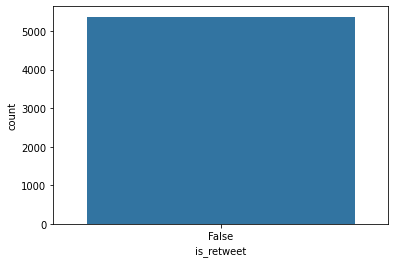

In [ ]:
sns.countplot(x = 'is_retweet', data = df)

#### Count number of current word in a tweet 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


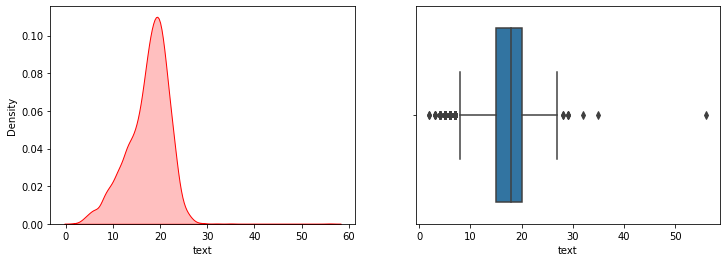

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(df['text'].str.count(' ') + 1,color='r',shade=True)
plt.subplot(1,2,2)
sns.boxplot(df['text'].str.count(' ') + 1)
plt.show()

the observation of the density represented makes it possible to note the length of the tweets seems almost to follow a normal law centered in 20. The boxplot confirms this impression. We note that with regard to the length of the tweets we find ourselves with 50% of the tweets which have less than 19 words and we observe a concentration of the length of the tweets mainly in the interval 10 to 27 words. Also as we cann see on the next lines we have an average length of 17 words.

In [ ]:
(df['text'].str.count(' ') + 1).mean()

17.415038153731622

#### Cleaning text

We are going to do some transformation in order to delete set of words or symbols fairly represented in the corpus but which do not provide additional informative values ​​for understanding it. They will therefore be deleted in the rest of our work to prevent them from slowing us down. It will be:
* transform tweet text into lowercase
* remove twitter handles (remove the user name)
* remove hyperlinks
* remove emoij

In this part, I have used the structure code from our course 

In [ ]:
# Remove weblinks
def remove_weblinks(text):
    text = re.sub(r"((https?:\/\/)|(www\.))(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", " ", text)
    text = re.sub(r"/forum/\S+"," ", text)
    return text.strip()

# Remove mentions characters
def remove_mentions(text):
    text = re.sub("(\S+)?@\S+", ' ', text)
    text = re.sub(r"^.+@", " ", text)
    return text.strip()

# Remove empty text
def replace_empty(text):
    if text == '' or str(text) == 'nan':
        return "nan"
    if re.match("\s+$", text):
        return "nan"
    return text

# Remove hashtag
def remove_hashtags(text):
    text = re.sub('(#\w+)', '', text)
    return text.strip()

# Applying Beautiful Soup (bs4) package to remove web characters (html) + remove emojis
def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are
    # matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def remove_emoji(text):
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
    cln_text = BeautifulSoup(text, 'lxml').get_text() # remove web characters
    cln_text = demoji.replace(cln_text, " ")
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       "]+", flags=re.UNICODE)

    cln_noemo = emoji_pattern.sub(r' ', cln_text)
    regex = get_emoji_regexp()
    cln_post = regex.sub(" ", cln_noemo)
    return (cln_post)

# Main function with preprocessing - please keep your eye on order of functions
def preprocess(text):
    text = str(text)
    text = remove_weblinks(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_emoji(text)
    text = replace_empty(text)
    text = re.sub("\s+"," ", text)
    text = re.sub("’", "'", text)
    text = re.sub("[“”·【】《》（）©£°¥«º»¿¤*~=%&€•@#…“”·、；！？【】《》（）©£¥«º»¿ðð¤_●–«» — — ´ ▽ ∀ ˊᗜ  ω  ▄ 〓█ ● ▂ █ ◥⊙ ▲ ⊙◤ ❶ ❷ ◍ ゜~ ← ▼ ω ♪ → ・｀ ღˇᴗˇ♡ ﾟ ]"," ",text)
    text = re.sub(r"(\bRT\b)"," ",text, flags = re.IGNORECASE|re.MULTILINE)
    text = re.sub(r"(\brt\b)"," ",text, flags = re.IGNORECASE|re.MULTILINE)
    text = re.sub(r"(\bretweet\b)"," ",text, flags = re.IGNORECASE|re.MULTILINE)
    text = re.sub("[-\/\(\)\\\[\]\|]", " ", text, flags = re.IGNORECASE|re.MULTILINE)
    text = re.sub(r"^\W+", "", text)
    text = re.sub(r"(^\W+)?(^from: \w+ on \w+)?",'',text,flags = re.IGNORECASE|re.MULTILINE)
    text = re.sub("\s+", " ", text)
    text = re.sub("⠀"," ", text)
    text = re.sub(r"^\W+", "", text)
    text = re.sub(r"\s+"," ", text)
    return text.strip()

In [ ]:
tqdm.pandas()

In [ ]:
df['processed_text'] = df['text'].progress_apply(preprocess)

  0%|          | 0/5373 [00:00<?, ?it/s]

In [ ]:
df.head()

,user_name,text,hashtags,is_retweet,processed_text
0,GoodMorningWilton,"Analyzing School Reopening Details, Wilton BOE...",NaN,False,"Analyzing School Reopening Details, Wilton BOE..."
1,Mitchel Bell,NICE Satmetrix Benchmark finds 57% of contact ...,NaN,False,NICE Satmetrix Benchmark finds 57 of contact c...
2,PIB India,"#CoronaWatch\n\n◾ 13,36,861 total confirmed ca...",['CoronaWatch'],False,"13,36,861 total confirmed cases 8,49,432 cases..."
3,Daniel Mumby,"""XR f***s up so often because we became way to...",NaN,False,XR f s up so often because we became way too b...
4,Jimmy Kokinakes,@realDonaldTrump America's most DISGRUNTLED EM...,['COVID19'],False,America's most DISGRUNTLED EMPLOYEE is Donald ...


#### Additionnal explonatory data analysis

We want to do additional analysis on the word which contains our corpus so we are going to do at first time a short preprocessing in order to delete number, special character and stopwords
stopwords (auxiliary words that can be ignored) are a set of words or symbols fairly represented in the corpus but which do not provide additional informative values ​​for understanding it. So we are going to delete them in order to do some analysis on important words of our corpus

In [ ]:
# Preprocessing step in order to delete stopwords
# loading libraries
import nltk
import string
from nltk.stem import WordNetLemmatizer
import re

In [ ]:
# Download stopwords and lemmatization function
nltk.download('stopwords')
nltk.download('punkt') # tokenizer divides a text into a list of sentences by using an unsupervised algorithm #to build a model for abbreviation words, collocations, and words that start sentences
nltk.download('words') # word from an english dictionnary 
nltk.download('wordnet') # another NLTK corpus reader
nltk.download('omw-1.4')

stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We can also remark that we did some lemmatization task. The process of lemmatization in natural language processing involves working with words according to their root lexical components. It is used in natural language processing and natural language understanding in computer programming and artificial intelligence.

In [ ]:
df['analyse_text'] = df['processed_text'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('(#\w+)', ' ')\
          .str.replace("[“”·【】《》（）©£°¥«º»¿¤*~=%&€•@#…“”·、；！？【】《》（）©£¥«º»¿ðð¤_●–«» — — ´ ▽ ∀ ˊᗜ  ω  ▄ 〓█ ● ▂ █ ◥⊙ ▲ ⊙◤ ❶ ❷ ◍ ゜~ ← ▼ ω ♪ → ・｀ ღˇᴗˇ♡ ﾟ ]", " ")

<ipython-input-150-0cf30b4336ba>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['analyse_text'] = df['processed_text'].str.lower()\


In [ ]:
# Creation of our function which allow us to create bag of words
def preprocessSentences(sentence):
    sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])

    sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

    tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)

    words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]

    words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
    
    words_lemmatize = (re.sub(r"[^a-zA-Z0-9]","",w) for w in words_lemmatize)

    sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())

    return sentence_clean.split()

In [ ]:
# Creation of dataset with sentence split with just pertinent word
df_words2 = df['analyse_text'].apply(preprocessSentences)
df_words2.head()

0    [school, detail, balk, growing, price, tag, we...
1    [nice, find, contact, center, employee, workin...
2       [total, confirmed, case, case, sample, tested]
3    [f, often, way, big, quickly, none, u, happening]
4                     [employee, trump, time, let, go]
Name: analyse_text, dtype: object

In [ ]:
# Onehotencoding on our dataset with just pertinent word
df_dumies_words = pd.get_dummies(df_words2.apply(pd.Series).stack()).sum(level=0)
df_dumies_words.head()

<ipython-input-153-6f977101833e>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_dumies_words = pd.get_dummies(df_words2.apply(pd.Series).stack()).sum(level=0)


,abandoned,abbey,abdication,ability,abject,ablaze,able,abnormal,abnormality,abortion,...,zeolite,zero,zimbabwe,zinc,zip,zombie,zone,zoo,zoom,zoonotic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Count the number of occurrences of each word
words_sum = df_dumies_words.sum(axis = 0).T
words_sum = words_sum.sort_values(ascending = False)

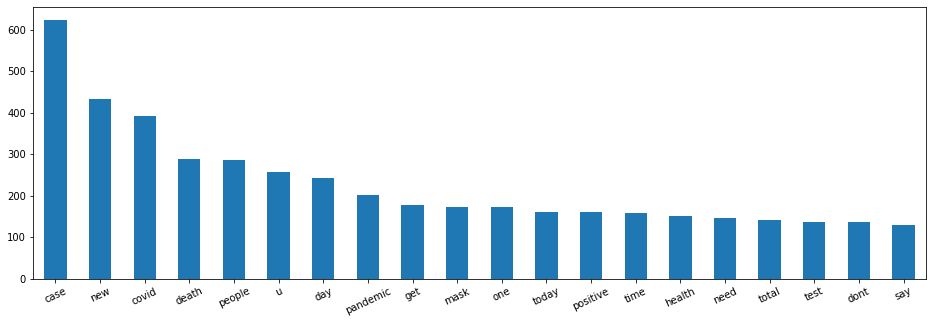

In [ ]:
# Graph the more used word
words_sum_max = words_sum.head(20)
plt.figure(figsize=(16,5))
words_sum_max.plot.bar(rot=25)

we can see that the most used words are words that have to do with the corona crisis. The most used word with more than 600 occurrences is the word case after this word we can find other words like new or covid. the general vocabulary of our corpus is so relative to the corona crisis

In [ ]:
# importation of library for creation of wordcloud
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

FreqDist allows us to determine the count of the most common terms in our corpus. So as we have already convert our individual lists of tokenized reviews into a comprehensive list of iterable tokens which stores all the reviews together.We will pass FreqDist() the “allwords” object and apply the “most_common(100)” function to obtain the 100 most common words.

In [ ]:
# Creation of a wordcloud
df_words2 = pd.DataFrame(df_words2)
words2 = df_words2['analyse_text']
allwords = []

for wordlist in words2:
    allwords += wordlist
print(allwords)

['school', 'detail', 'balk', 'growing', 'price', 'tag', 'weve', 'got', 'everything', 'need', 'nice', 'find', 'contact', 'center', 'employee', 'working', 'home', 'due', 'covid', 'total', 'confirmed', 'case', 'case', 'sample', 'tested', 'f', 'often', 'way', 'big', 'quickly', 'none', 'u', 'happening', 'employee', 'trump', 'time', 'let', 'go', 'late', 'stage', 'human', 'trial', 'vaccine', 'trial', 'include', 'par', 'independence', 'covid', 'patient', 'case', 'rise', 'help', 'slow', 'spread', 'identify', 'risk', 'case', 'sooner', 'self', 'symptom', 'daily', 'even', 'know', 'country', 'eu', 'deliberately', 'citizen', 'locked', 'whole', 'c', 'let', 'pick', 'used', 'inverter', 'battery', 'kind', 'pay', 'cash', 'v', 'ah', 'k', 'k', 'please', 'call', 'never', 'hoped', 'life', 'truly', 'desire', 'people', 'responsible', 'bur', 'rebellious', 'patient', 'finally', 'agree', 'shift', 'covid', 'care', 'center', 'mayor', 'commissioner', 'c', 'international', 'student', 'forced', 'distance', 'learning',

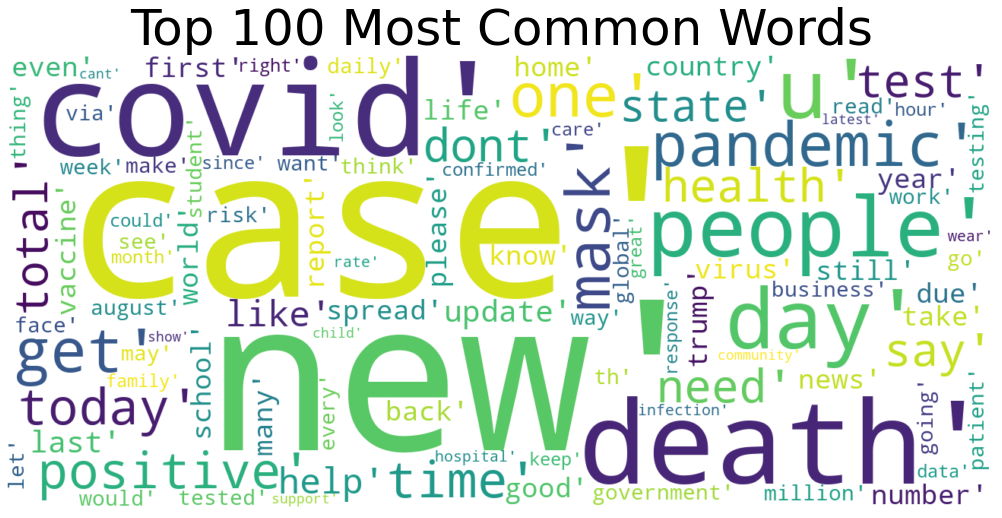

In [ ]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1300, height=600, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(23,7), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

We can have a direct representation of the most used word and it confirm the result we obtained previously

## Part 2: BERT-like sentence embeddings


First, we need to represent the text data numerically. One approach is to create an embedding (vector representation) of each word to use for clustering. To do that, we had applied Bert embedding.

We know that the initial embedding techniques dealt only with words. Given a set of words, generate an embedding for each word in the set. 

Sentence embedding techniques represent entire sentences and their semantic information as vectors, helping machines understand the context, and other nuances of the entire text.

We have some technique can be a selection: 

* Doc2Vec

* SentenceBERT

* InferSent

* Universal Sentence Encoder

Released in late 2018, BERT (Bidirectional Encoder Representations from Transformers) is the model we will use in this project to provide a better understanding and using transfer learning models in NLP. BERT is a method of pre-training linguistic representations that has been used to create models that NLP practitioners can download and use for free.

In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.2 MB/s 
     |████████████████████████████████| 5.8 MB 67.6 MB/s 
     |████████████████████████████████| 1.3 MB 63.9 MB/s 
     |████████████████████████████████| 182 kB 73.2 MB/s 
     |████████████████████████████████| 7.6 MB 64.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=4c63596d6456b44a16d715d288d71c4cd7e3d4a30eaec1cecb91c8a1524770eb
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
sentence_embeddings = model.encode(df['processed_text'].astype(str).tolist())

In [ ]:
sentence_embeddings

array([[ 0.0243596 ,  0.6766973 ,  1.3260695 , ...,  0.50258374,
        -0.2600192 ,  0.22518586],
       [-0.20052096,  0.3453474 ,  0.07153768, ...,  0.3186567 ,
         0.611083  ,  0.41031957],
       [-0.19005015,  0.4938184 ,  0.57015866, ...,  0.26780036,
         0.7798597 ,  0.03556852],
       ...,
       [ 0.61150676,  0.2709905 ,  1.521274  , ..., -0.01600011,
         0.3598536 , -0.20730405],
       [ 0.2966606 ,  0.22809716,  0.7806469 , ..., -0.6223533 ,
        -0.1964362 , -0.17442265],
       [ 0.345413  ,  0.19180672,  2.0319326 , ..., -0.72015524,
         0.00385456,  0.05457607]], dtype=float32)

In [ ]:
sentence_embeddings.shape

(5373, 768)

From the data frame above, we can see that the data set has 768 dimensions. This is the standard output of the BERT model, regardless of the initial length of input text provided.

## Part 3: PCA

However, as the dimensionality increases to 768, the volume space can grow rapidly, leading to some problems. One is that the available data can be sparse. This makes machine learning models less effective and increases computational complexity exponentially. Specially when we want to use the HBSCAN(clustering),  distance measures, such as Euclidean and Manhattan is becomed meaningless at such high dimensions. This problem is called the dimensionality "curse" and can be addressed by dimensionality reduction techniques. Because our model is based on clustering, therefore we will apply Principal Component Analysis PCA to reduce the complexity of dimension. The PCA is maximize variance of features in the dataset using eigenvectors and eigenvalues (on other hand, the PCA will look for some features with the same characteristic)

A key determinant in this process is the number of principal components that should be chosen to keep as many of the initial predictors of the dataset as possible.

Unlike PLS, we can not compute Mean squared error to select the optimal number of component. In this section, we will compute the mean of sentence to select the optimal hyperparameter.

In [ ]:
# get average length of sentences for finding the optimal number of PCA components
length = []
for i in range(len(df)):
    length.append(len(df['processed_text'][i]))
print(f'Average length of the text input is {round(np.mean(length),0)}')
print(f'Maximum length of the text input is {round(np.max(length),0)}')
print(f'Standard deviation in length of the text input is {round(np.std(length),0)}')

Average length of the text input is 83.0
Maximum length of the text input is 132
Standard deviation in length of the text input is 28.0


The text dataset present a mean is around 83 and maximum equals to 132 (32% higher than mean) with small deviation (A coefficient of variation = 28/132 = 0.4). Then when we apply number of component = 83, it may not good robust and accurate results.

In [ ]:
pickle_out = open("embeddings.p","wb")
pickle.dump(sentence_embeddings, pickle_out)
pickle_out.close()

In [ ]:
def pca(message_embeddings, nb):
    pca = PCA(n_components = nb)
    newX = pca.fit_transform(message_embeddings)
    newdf = pd.DataFrame(newX)
    newdf.to_pickle('pca.p')
    print('Variance of first 50 principal components is', np.around(pca.explained_variance_ratio_,6)[:50])
    return (newX)

In [ ]:
df_embed = pca(sentence_embeddings, 83)

Variance of first 50 principal components is [0.120419 0.094936 0.058841 0.047094 0.042786 0.030262 0.02899  0.026272
 0.022291 0.020262 0.016599 0.015764 0.015087 0.013612 0.012857 0.012348
 0.011776 0.010786 0.010198 0.010099 0.009177 0.00879  0.00835  0.008091
 0.007908 0.007538 0.007154 0.006823 0.006665 0.006333 0.005966 0.005914
 0.005736 0.005454 0.00523  0.004918 0.004714 0.00455  0.004488 0.004394
 0.004129 0.004002 0.003971 0.003892 0.003718 0.003656 0.003542 0.003473
 0.003453 0.003215]


We can see that the explained variance for the first component is 12.04 and then decreases sharply for each component, reaching 0.32 at the 50th component. This suggests that a much smaller number of components can adequately describe the variance of the dataset. Also, we will plot the cumulative variance to find the threshold that explains 95% of the variance.

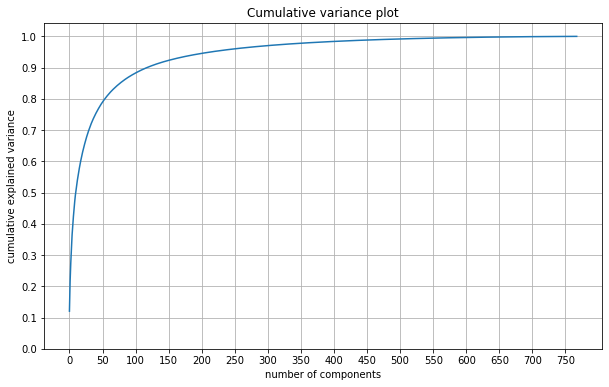

In [ ]:
pca_768 = PCA(n_components=768).fit(sentence_embeddings)
var_ratio = pca_768.explained_variance_ratio_


plt.figure(figsize=(10,6))
plt.plot(np.cumsum(var_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative variance plot')
plt.yticks(np.arange(0,1.1, 0.1))
plt.xticks(np.arange(0,800, 50))
plt.grid()

In [ ]:
req_var = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
for var in req_var:
  c = 0
  i = -1
  while c <= var:
    i += 1
    c = c + var_ratio[i]
  print('Number of components to explain', '{:.0f}%'.format(var*100), 'of variance is', '{}'.format(i+1))

Number of components to explain 50% of variance is 11
Number of components to explain 60% of variance is 18
Number of components to explain 70% of variance is 31
Number of components to explain 80% of variance is 55
Number of components to explain 90% of variance is 119
Number of components to explain 95% of variance is 215
Number of components to explain 99% of variance is 474


From the above analysis, we can conclude that the optimal number of principal components for dimensionality reduction is 215 as it explains 95% of the variance.

In [ ]:
df_embed = pca(sentence_embeddings, 215)

Variance of first 50 principal components is [0.120419 0.094936 0.058841 0.047094 0.042786 0.030262 0.02899  0.026272
 0.022291 0.020262 0.016599 0.015764 0.015087 0.013612 0.012857 0.012348
 0.011776 0.010786 0.010198 0.010099 0.009177 0.00879  0.00835  0.008091
 0.007908 0.007538 0.007154 0.006823 0.006665 0.006333 0.005966 0.005914
 0.005736 0.005454 0.00523  0.004918 0.004714 0.00455  0.004488 0.004394
 0.004129 0.004002 0.003971 0.003892 0.003718 0.003656 0.003542 0.003474
 0.003453 0.003216]


In [ ]:
df_embed 

array([[ 0.7154731 ,  3.5867562 , -2.6441154 , ..., -0.08784693,
        -0.02660749,  0.02007416],
       [-4.952541  , -3.3455136 , -1.8461803 , ..., -0.24582827,
        -0.15894401, -0.1504413 ],
       [-4.284419  , -4.1770225 ,  0.64000714, ...,  0.7567282 ,
         0.4834385 , -0.08797197],
       ...,
       [ 5.5880637 , -2.0046988 ,  1.9484633 , ..., -0.22177938,
         0.08972923,  0.04165028],
       [ 0.36460614,  2.8976872 ,  2.1403215 , ...,  0.01469706,
        -0.05236068, -0.2760767 ],
       [ 5.552492  ,  7.459114  ,  7.862227  , ...,  0.18325494,
        -0.01267167,  0.1974462 ]], dtype=float32)

## Part 4: Clustering



HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander. They transform and extend DBSCAN into a hierarchical clustering algorithm and use a technique to extract clustering based on cluster stability.
To use HDBSCAN, it is really important to select the hyperparameter to have the better performance.

We consider some important parameters:


*   The first one is min_samples = minimum number of neighboring points to a core point. The higher this is, the more points will be discarded as noise/outliers.
*   The second one is min_cluster_size: minimum size the final cluster can have. The higher this is, the larger the cluster. This is from the H part of HDBSc.




In [ ]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 23.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=2700830 sha256=06ae0c123370bc6503f422cabbec2908fe1c3a09a7840000f504da14a9c46341
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import hdbscan
from sklearn.metrics import make_scorer
import logging
import warnings
from sklearn.manifold import TSNE

In [ ]:
warnings.simplefilter('ignore')

In [ ]:
logging.captureWarnings(True)
hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(df_embed)

# specify parameters and distributions to sample from
param_dist = {'min_samples': [5,8,10,15, 20],
              'min_cluster_size':[10,15,20,25,30, 40, 50, 60],  
              'cluster_selection_method' : ['eom','leaf'],
              'metric' : ['euclidean','manhattan'] 
             }

#validity_scroer = "hdbscan__hdbscan___HDBSCAN__validity_index"
validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)


n_iter_search = 20
random_search = RandomizedSearchCV(hdb
                                   ,param_distributions=param_dist
                                   ,n_iter=n_iter_search
                                   ,scoring=validity_scorer 
                                   ,random_state = 123)

random_search.fit(df_embed)


print(f"Best Parameters {random_search.best_params_}")

Best Parameters {'min_samples': 10, 'min_cluster_size': 25, 'metric': 'manhattan', 'cluster_selection_method': 'leaf'}


From `RandomizedSearchCV`, we will select the min sample 18, and min cluster size equals to 15, and we will try to scatter to see our cluster. Since HDBSCAN is unsupervised learning, we can not directly measure the performance of model by accracy, the only thig we can do is making a plot to see the result 

In [ ]:
projection = TSNE().fit_transform(df_embed)

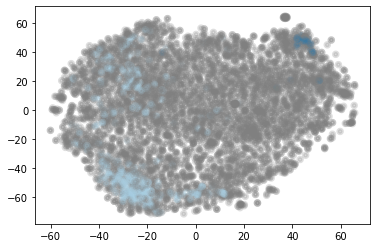

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size= 25, min_samples = 10, metric= 'manhattan', cluster_selection_method ='leaf').fit(df_embed)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s = 20, linewidth=-3, c=cluster_member_colors, alpha=0.25)

From this graphic, we can see that, our performance is not really good. We can explain this performance by a reason: Because we choose to import the data Tweets in covid 19 period, almost tweets told about the topic covid. We can see those impacts on the graphic, all points were crowned in centre. Therefore, it is really difficult to have a good split in each cluster in this situation.




In [ ]:
model_hdbscan = hdbscan.HDBSCAN(min_cluster_size= 25, min_samples = 10, metric= 'manhattan', cluster_selection_method ='leaf')
labels = model_hdbscan.fit_predict(df_embed)

In [ ]:
df['cluster'] = labels.tolist()

In [ ]:
df['cluster'].value_counts()

-1    4834
 0     476
 1      63
Name: cluster, dtype: int64

In [ ]:
print(df[df.cluster == -1]["hashtags"].unique())

[nan "['COVID19']" "['BoycottMadeInChina', 'CCPChina', 'COVID19']" ...
 "['Boxhill']"
 "['DarceyAndStacey', 'PValley', '90DayFianceHappilyEverAfter', 'COVID19', 'FiveForWynonna']"
 "['Mets']"]


In [ ]:
df

,user_name,text,hashtags,is_retweet,processed_text,cluster,seg,id
0,GoodMorningWilton,"Analyzing School Reopening Details, Wilton BOE...",NaN,False,"Analyzing School Reopening Details, Wilton BOE...",-1,"[Analyzing School Reopening Details, Wilton BO...",0
1,Mitchel Bell,NICE Satmetrix Benchmark finds 57% of contact ...,NaN,False,NICE Satmetrix Benchmark finds 57 of contact c...,-1,[NICE Satmetrix Benchmark finds 57 of contact ...,1
2,PIB India,"#CoronaWatch\n\n◾ 13,36,861 total confirmed ca...",['CoronaWatch'],False,"13,36,861 total confirmed cases 8,49,432 cases...",0,"[13,36,861 total confirmed cases 8,49,432 case...",2
3,Daniel Mumby,"""XR f***s up so often because we became way to...",NaN,False,XR f s up so often because we became way too b...,-1,[XR f s up so often because we became way too ...,3
4,Jimmy Kokinakes,@realDonaldTrump America's most DISGRUNTLED EM...,['COVID19'],False,America's most DISGRUNTLED EMPLOYEE is Donald ...,0,[America's most DISGRUNTLED EMPLOYEE is Donald...,4
...,...,...,...,...,...,...,...,...
5368,Dan Male,Karamjit is absolutely right to talk about the...,['NHS'],False,Karamjit is absolutely right to talk about the...,-1,[Karamjit is absolutely right to talk about th...,5368
5369,The New Indian Express,UN chief says over one billion students are af...,['COVID19'],False,UN chief says over one billion students are af...,-1,[UN chief says over one billion students are a...,5369
5370,Diamond Q,Follow or you gay 👀 #DarceyAndStacey #PValley ...,"['DarceyAndStacey', 'PValley', '90DayFianceHap...",False,Follow or you gay,-1,[Follow or you gay],5370
5371,Richard herlihy,@L5Roby @ChristianDMZ @andifasano @meliswein @...,['Mets'],False,BREAKING NEWS GM Brodie Van Wagenen a,-1,[BREAKING NEWS GM Brodie Van Wagenen a],5371


##Part 5: Sentence Segmentation

An important part of NLP is playing on similarities in high-dimensional space. Typically NLP solutions take some text, process it to create a large vector/array representing that text, and perform some transformations.

We present some steps of this part:


1.   Take the first sentence and convert it to a vector.
2.   Convert many other sentences to vectors.
3.   Find the sentence with the smallest angle (cosine similarity) (higher cosine similarity)

To convert them to a vector, we keep to use BERT, like part 2, but we do not need to convert the data to smaller dimension



In [ ]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df_seg = df
nlp = spacy.load("en_core_web_sm")
df_seg["seg"] = df_seg["processed_text"].apply(lambda x: [sent.text for sent in nlp(x).sents])

Transform list of sentences to one sentence in each row

In [ ]:
df_seg['id'] = df_seg.index

In [ ]:
df_seg = df_seg.explode("seg", ignore_index=True)

In [ ]:
seg_embeddings = model.encode(df_seg['seg'])
seg_embeddings.shape

(8063, 768)

In [ ]:
cosine = cosine_similarity([seg_embeddings[0]],seg_embeddings[0:])
cosine[0]


array([0.99999994, 0.05662068, 0.36648202, ..., 0.30116823, 0.573419  ,
       0.3816809 ], dtype=float32)

In [ ]:
df_seg['cosine'] = cosine[0].tolist()

Here is our result

In [ ]:
df_seg

,user_name,text,hashtags,is_retweet,processed_text,cluster,seg,id,cosine
0,GoodMorningWilton,"Analyzing School Reopening Details, Wilton BOE...",NaN,False,"Analyzing School Reopening Details, Wilton BOE...",-1,"Analyzing School Reopening Details, Wilton BOE...",0,1.000000
1,GoodMorningWilton,"Analyzing School Reopening Details, Wilton BOE...",NaN,False,"Analyzing School Reopening Details, Wilton BOE...",-1,We've got everything you need to,0,0.056621
2,Mitchel Bell,NICE Satmetrix Benchmark finds 57% of contact ...,NaN,False,NICE Satmetrix Benchmark finds 57 of contact c...,-1,NICE Satmetrix Benchmark finds 57 of contact c...,1,0.366482
3,PIB India,"#CoronaWatch\n\n◾ 13,36,861 total confirmed ca...",['CoronaWatch'],False,"13,36,861 total confirmed cases 8,49,432 cases...",3,"13,36,861 total confirmed cases 8,49,432 cases...",2,0.380740
4,Daniel Mumby,"""XR f***s up so often because we became way to...",NaN,False,XR f s up so often because we became way too b...,-1,XR f s up so often because we became way too b...,3,0.585390
...,...,...,...,...,...,...,...,...,...
8058,The New Indian Express,UN chief says over one billion students are af...,['COVID19'],False,UN chief says over one billion students are af...,-1,UN chief says over one billion students are af...,5369,0.497104
8059,The New Indian Express,UN chief says over one billion students are af...,['COVID19'],False,UN chief says over one billion students are af...,-1,Follow LIVE update,5369,0.092686
8060,Diamond Q,Follow or you gay 👀 #DarceyAndStacey #PValley ...,"['DarceyAndStacey', 'PValley', '90DayFianceHap...",False,Follow or you gay,-1,Follow or you gay,5370,0.301168
8061,Richard herlihy,@L5Roby @ChristianDMZ @andifasano @meliswein @...,['Mets'],False,BREAKING NEWS GM Brodie Van Wagenen a,-1,BREAKING NEWS GM Brodie Van Wagenen a,5371,0.573419


# Conclusion

In summary, we have shown how to applied PCA to reduce dimensionlity before using HDBSCAN to get the better performance. However, our result performance is not really good because the most of tweets told about the Covid crisis 

The next part, we used BERT to measure the semantic similarity of sentences - using both a sentence transformer and a lower-level implementation using transformers.

# References
Course: Bigdata and Marketing AMSE

[Topic Modeling with Deep Learning Using Python BERTopic](https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504)

[Parameter Selection for HDBSCAN](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)

https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html

https://inside-machinelearning.com/eda-sur-nlp/

https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

*Natural Language Processing with Python*, Steven Bird, Ewan Klein, Edward Loper

Ian T. Jolliffe and Jorge Cadima- Principal component analysis: a review and recent developments
